In [76]:
import sys
sys.path.append('../')

from typing import Union, Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

from src.utils import get_data_and_feed
from scipy.integrate import odeint

import torch
import torch.nn as nn
from tqdm import tqdm 

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


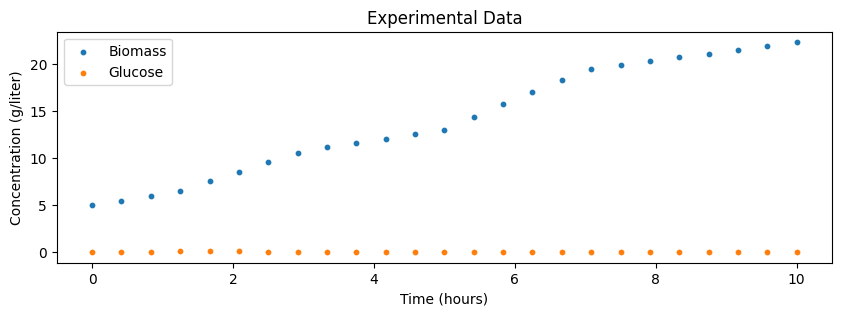

In [77]:
T_START = 0
T_END = 10
NUM_SAMPLES = 25

# parameter values
mumax = 0.88      # 1/hour
Ks = 0.20         # g/liter
Yxs = 0.5         # g/g
Sin = 1.43 * 200        # g/liter

# inlet flowrate
def Fs(t):
    if t < 1.2:
        return 0.01
    if t < 3:
        return 0.02
    elif t < 5:
        return 0.01
    elif t < 7:
        return 0.03
    else:
        return 0.01

def simulate(mumax, Ks, Yxs, Sin, T_START, T_END, NUM_SAMPLES):
    
    mumax = mumax
    Ks = Ks
    Yxs = Yxs
    
    # reaction rates
    def mu(S):
        return mumax*S/(Ks + S)

    def Rg(X,S):
        return mu(S)*X

    # differential equations
    def xdot(x,t):
        X,S,V = x
        dX = -Fs(t)*X/V + Rg(X,S)
        dS = Fs(t)*(Sin-S)/V - Rg(X,S)/Yxs
        dV = Fs(t)
        return [dX,dS,dV]

    IC = [5, 0.01, 1.1]

    t = np.linspace(T_START,T_END,NUM_SAMPLES)
    sol = odeint(xdot,IC,t)

    return sol

X,S,V = simulate(mumax, Ks, Yxs, Sin, T_START, T_END, NUM_SAMPLES).transpose()

# Generate dataset 
t = np.linspace(T_START,T_END,NUM_SAMPLES)
full_df = pd.DataFrame({'RTime': t, 'Biomass': X, 'Glucose': S, 'V': V})

# Plot 
plt.figure(figsize=(10,3))  
plt.scatter(t,X,s=10,label='Biomass')
plt.scatter(t,S,s=10,label='Glucose')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (g/liter)')
plt.title('Experimental Data')
plt.legend()
plt.show()

In [78]:
def numpy_to_tensor(array):
    return (
        torch.tensor(array, requires_grad=True, dtype=torch.float32)
        .to(DEVICE)
        .reshape(-1, 1)
    )

class PINN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        t_start: Union[np.float32, torch.Tensor],
        t_end: Union[np.float32, torch.Tensor],
    ):
        super().__init__()
        self.input = nn.Linear(input_dim, 32)
        self.hidden = nn.Linear(32, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 256) 
        self.output = nn.Linear(256, output_dim)

        self.mu_max = nn.Parameter(torch.tensor([0.5]))
        self.K_s = nn.Parameter(torch.tensor([0.5]))
        self.Y_xs = nn.Parameter(torch.tensor([0.5]))

        self.t_start = t_start
        self.t_end = t_end
        if isinstance(self.t_start, torch.Tensor):
            self.t_start = self.t_start.item()
        if isinstance(self.t_end, torch.Tensor):
            self.t_end = self.t_end.item()

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.hidden(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.output(x)
        return x
    
def loss_fn(
    net: torch.nn.Module,
    t_start: Union[np.float32, torch.Tensor],
    t_end: Union[np.float32, torch.Tensor],
) -> torch.Tensor:
    
    if isinstance(t_start, torch.Tensor):
        t_start = t_start.item()
    if isinstance(t_end, torch.Tensor):
        t_end = t_end.item()

    t = torch.linspace(t_start, t_end, steps=50).view(-1, 1).requires_grad_(True).to(DEVICE)

    F = torch.tensor(np.array([Fs(t.detach().cpu().numpy()) for t in t]), dtype=torch.float32).view(-1, 1).to(DEVICE)
    
    u_pred = net.forward(t)
    X_pred = u_pred[:, 0].view(-1, 1)
    S_pred = u_pred[:, 1].view(-1, 1)
    V_pred = u_pred[:, 2].view(-1, 1)

    dXdt_pred = torch.autograd.grad(
        X_pred, t, grad_outputs=torch.ones_like(X_pred), create_graph=True
    )[0]
    dSdt_pred = torch.autograd.grad(
        S_pred, t, grad_outputs=torch.ones_like(S_pred), create_graph=True
    )[0]
    dVdt_pred = torch.autograd.grad(
        V_pred, t, grad_outputs=torch.ones_like(V_pred), create_graph=True
    )[0]

    mu = net.mu_max * S_pred / (net.K_s + S_pred)

    error_dXdt = nn.MSELoss()(
        dXdt_pred, mu * X_pred - X_pred * F / V_pred
    )
    error_dSdt = nn.MSELoss()(
        dSdt_pred, - mu * X_pred / net.Y_xs + F / V_pred * (Sin - S_pred)
    )
    error_dVdt = nn.MSELoss()(
        dVdt_pred, torch.ones_like(dVdt_pred) * F
    )

    error_ode = error_dXdt + error_dSdt + error_dVdt
    return error_ode


In [79]:
TRAIN_SIZE = NUM_SAMPLES - 5
t_train = np.linspace(T_START,T_END,TRAIN_SIZE)
df = full_df.iloc[:TRAIN_SIZE].copy()

In [80]:
t_train = numpy_to_tensor(t_train).to(DEVICE)
Biomass_train = numpy_to_tensor(df["Biomass"].values).to(DEVICE)
Glucose_train = numpy_to_tensor(df["Glucose"].values).to(DEVICE)
V_train = numpy_to_tensor(df["V"].values).to(DEVICE)
u_train = torch.cat((Biomass_train, Glucose_train, V_train), 1).to(DEVICE)

net = PINN(1,3,T_START, T_END).to(DEVICE)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

def train(net, optimizer, t_train, u_train):
    # Initialize early stopping variables
    best_loss = float('inf')
    best_model_weights = None
    patience = 100

    num_epochs = 10000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        u_pred = net.forward(t_train)
        
        # if epoch == 100:
        #     if torch.any(u_pred < 0):
        #         raise ValueError("Initial prediction is negative")
            
        # Data loss
        X_data_loss = nn.MSELoss()(u_pred[:,0], u_train[:,0])
        S_data_loss = nn.MSELoss()(u_pred[:,1], u_train[:,1])
        V_data_loss = nn.MSELoss()(u_pred[:,2], u_train[:,2])
        loss_data = X_data_loss + S_data_loss + V_data_loss
        
        # IC loss
        X_ic_loss = nn.MSELoss()(u_pred[0,0], u_train[0,0])
        S_ic_loss = nn.MSELoss()(u_pred[0,1], u_train[0,1])
        V_ic_loss = nn.MSELoss()(u_pred[0,2], u_train[0,2])
        loss_ic = X_ic_loss + S_ic_loss + V_ic_loss
        
        # ODE loss
        loss_ode = loss_fn(net, T_START, T_END)
        
        # Total Loss
        loss = loss_data + loss_ic + loss_ode
        loss.backward()
        optimizer.step()
        
        if epoch % 250 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f} data loss: {loss_data.item():.4f}, IC loss: {loss_ic.item():.4f}, ODE loss: {loss_ode.item():.4f}")
            print(f"mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}")

        # Early stopping
        if loss <= 1.0:
            if loss < best_loss:
                best_loss = loss
                best_model_weights = copy.deepcopy(net.state_dict())
                patience = 100
            else:
                patience -= 1
                if patience == 0:
                    print(f"Early stopping at epoch {epoch}")   
                    net.load_state_dict(best_model_weights)
                    break  
            
    t_test = torch.linspace(T_START, T_END, 100).view(-1, 1).to(DEVICE)
    net_df = pd.DataFrame()
    net_df['RTime'] = t_test.cpu().detach().numpy().flatten()   
    net_df['Biomass'] = net(t_test).cpu().detach().numpy()[:,0]
    net_df['Glucose'] = net(t_test).cpu().detach().numpy()[:,1]
    net_df['V'] = net(t_test).cpu().detach().numpy()[:,2]
    
    return net, net_df, loss

In [81]:
repeat = True
while repeat:
    try:
        net, net_df, loss = train(net, optimizer, t_train, u_train)
        repeat = False
    except ValueError:
        pass

Epoch 0 | Loss: 12092589.0000 data loss: 175.7890, IC loss: 26.7562, ODE loss: 12092386.0000
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001


Epoch 250 | Loss: 115.1973 data loss: 90.8152, IC loss: 15.6620, ODE loss: 8.7202
mu_max: 0.5154, K_s: 0.4837, Y_xs: 0.4831
Epoch 500 | Loss: 3.8650 data loss: 1.5290, IC loss: 0.0852, ODE loss: 2.2508
mu_max: 0.5122, K_s: 0.4790, Y_xs: 0.4919
Epoch 750 | Loss: 2.3851 data loss: 0.6289, IC loss: 0.0956, ODE loss: 1.6606
mu_max: 0.5154, K_s: 0.4744, Y_xs: 0.4930
Epoch 1000 | Loss: 1.9722 data loss: 0.5588, IC loss: 0.0509, ODE loss: 1.3626
mu_max: 0.5176, K_s: 0.4705, Y_xs: 0.4967
Epoch 1250 | Loss: 1.5985 data loss: 0.5395, IC loss: 0.0317, ODE loss: 1.0273
mu_max: 0.5229, K_s: 0.4628, Y_xs: 0.4976
Epoch 1500 | Loss: 1.3447 data loss: 0.5085, IC loss: 0.0206, ODE loss: 0.8155
mu_max: 0.5306, K_s: 0.4517, Y_xs: 0.4952
Epoch 1750 | Loss: 1.2149 data loss: 0.4696, IC loss: 0.0157, ODE loss: 0.7296
mu_max: 0.5380, K_s: 0.4407, Y_xs: 0.4918
Epoch 2000 | Loss: 1.1366 data loss: 0.4336, IC loss: 0.0142, ODE loss: 0.6889
mu_max: 0.5443, K_s: 0.4313, Y_xs: 0.4889
Epoch 2250 | Loss: 1.0710 data 

In [82]:
print(f'Loss: {loss.item():.4f}')
print(f'mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}')

Loss: 0.6785
mu_max: 0.5878, K_s: 0.3598, Y_xs: 0.4811


In [83]:
t_test = np.linspace(T_START,T_END,100)
X_test,S_test,V_test = simulate(net.mu_max.item(), net.K_s.item(), net.Y_xs.item(), Sin, T_START, T_END, 100).transpose()

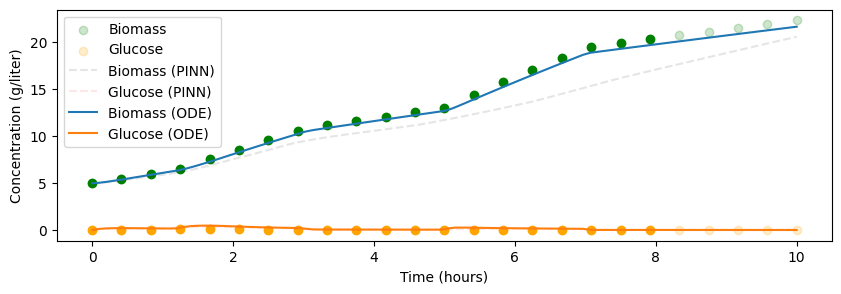

In [84]:
plt.figure(figsize=(10,3))
plt.scatter(full_df['RTime'],full_df['Biomass'],label='Biomass', color='green', alpha=0.2)
plt.scatter(full_df['RTime'],full_df['Glucose'],label='Glucose', color='orange', alpha=0.2)
plt.scatter(df['RTime'],df['Biomass'],label='_Biomass', color='green', alpha=1.0)
plt.scatter(df['RTime'],df['Glucose'],label='_Glucose', color='orange', alpha=1.0)

plt.plot(net_df['RTime'],net_df['Biomass'],label='Biomass (PINN)', linestyle='--', color='black', alpha=0.1)
plt.plot(net_df['RTime'],net_df['Glucose'],label='Glucose (PINN)', linestyle='--', color='red', alpha=0.1)

plt.plot(t_test,X_test,label='Biomass (ODE)')
plt.plot(t_test,S_test,label='Glucose (ODE)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (g/liter)')
plt.legend()
plt.show()